## Final Project (DL,CV,NLP) - Image Captioning in Hindi
### Anush Verma (2348504)
### Himanshu Gulechha (2348520)
### Manashwy Padhi (2348528)

### Importing the libraries

In [134]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltl.translate.
from PIL import Image
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Loading the Images and captions

In [2]:
images_directory = '/Users/himanshugulechha/Desktop/MSc AI&ML/Sem3/Project/archive/Images/'

captions_path = '/Users/himanshugulechha/Desktop/MSc AI&ML/Sem3/Project/archive/captions.txt'

In [3]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)


### Preprcoessing the captions

In [4]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]

In [5]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)
captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

### Displaying the dataset

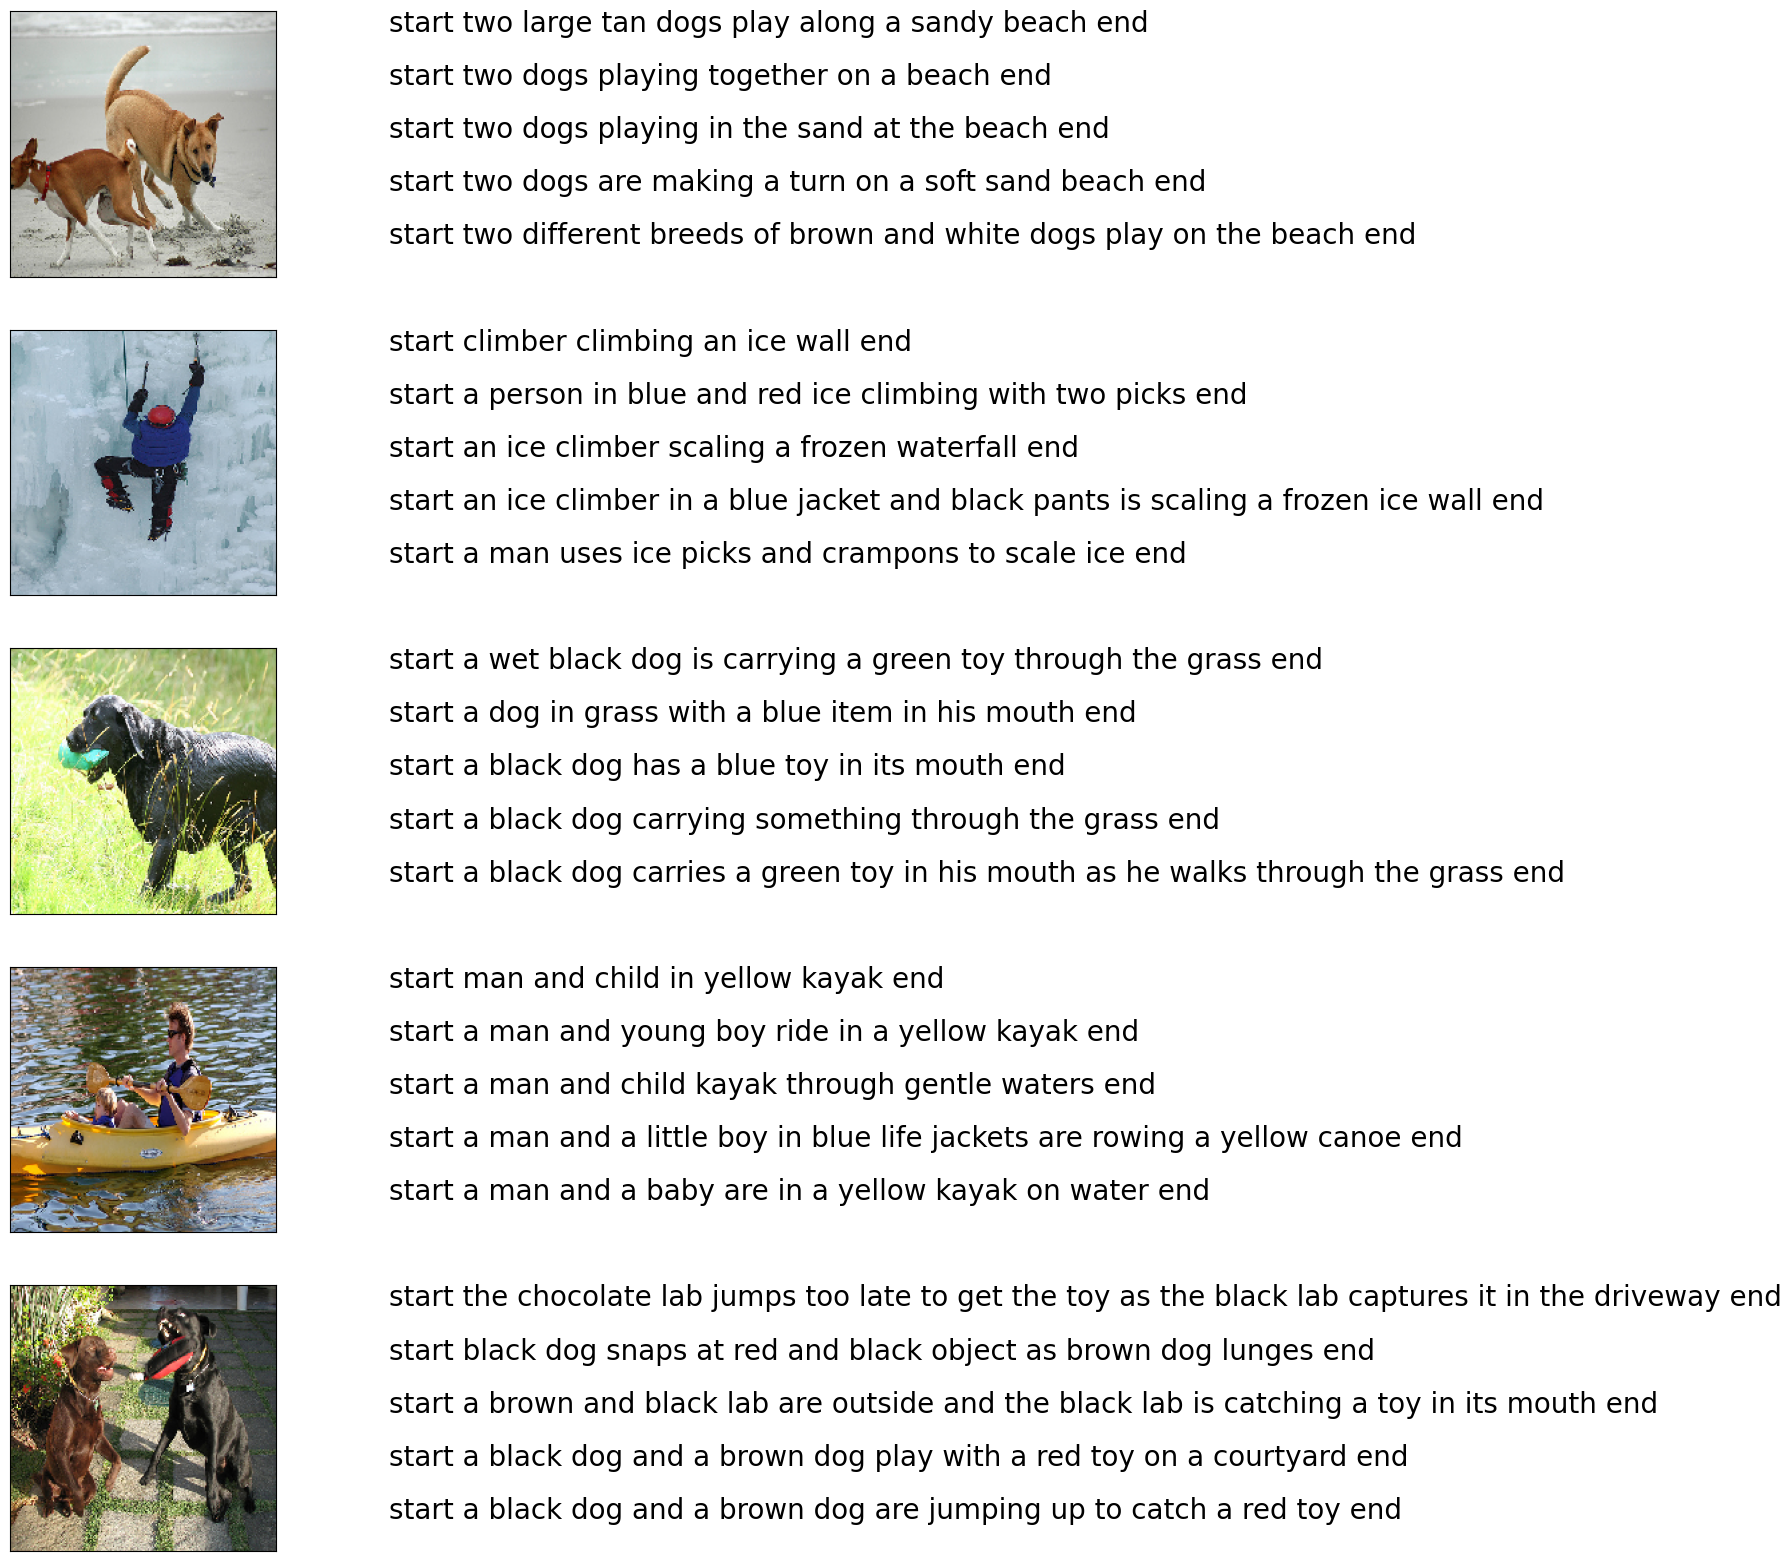

In [6]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(captions_IDs, 5)

In [7]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

### Splitting images into training, validation and testing dataset

In [9]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    
    if image_id in train_image_ids:
        train_captions.append(caption)
        
    elif image_id in val_image_ids:
        val_captions.append(caption)        

    elif image_id in test_image_ids:
        test_captions.append(caption)
        
    else:
        print('Unknown image ID !')

### Extracting features using InceptionV3

In [31]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(200, 200))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(200, 200, 3), include_top=False)
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

### Distributing the features according to previous split

In [13]:
train_image_features, val_image_features, test_image_features = {}, {}, {} 


for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path)
    
    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  
    
    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  
    
    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()
    
    else:
        print('Unknown image ID !')
    

### Data generation for training and validation

In [33]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] 
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            
            yield [np.array(X_images), np.array(X_captions)], np.array(y)
         
        
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1
cnn_output_dim = 3072

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, 270)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, 150)

### Checking the shapes

In [34]:
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3186, 3072)
X_captions: (3186, 34)
y: (3186, 8586)
Validation sample batch shapes:
X_images: (1797, 3072)
X_captions: (1797, 34)
y: (1797, 8586)


### Building the model

In [169]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) 
    fe3 = BatchNormalization()(fe2)
    
    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size,256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)
    
    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model
    
# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Features_Input (InputLayer  [(None, 3072)]               0         []                            
 )                                                                                                
                                                                                                  
 batch_normalization_574 (B  (None, 3072)                 12288     ['Features_Input[0][0]']      
 atchNormalization)                                                                               
                                                                                                  
 Sequence_Input (InputLayer  [(None, 34)]                 0         []                            
 )                                                                                 

### Fitting the Model with early stopping

In [171]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // 270,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // 150,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Epoch 1/15
127/127 [==============================] - 154s 1s/step - loss: 4.4523 - accuracy: 0.2475 - val_loss: 3.9208 - val_accuracy: 0.3069 - lr: 0.0030
Epoch 2/15
127/127 [==============================] - 154s 1s/step - loss: 3.5238 - accuracy: 0.3308 - val_loss: 3.6175 - val_accuracy: 0.3335 - lr: 0.0017
Epoch 3/15
127/127 [==============================] - 152s 1s/step - loss: 3.1866 - accuracy: 0.3601 - val_loss: 3.5246 - val_accuracy: 0.3470 - lr: 9.0718e-04
Epoch 4/15
127/127 [==============================] - 153s 1s/step - loss: 2.9998 - accuracy: 0.3775 - val_loss: 3.4833 - val_accuracy: 0.3525 - lr: 4.9787e-04
Epoch 5/15
127/127 [==============================] - 153s 1s/step - loss: 2.8917 - accuracy: 0.3879 - val_loss: 3.4634 - val_accuracy: 0.3552 - lr: 2.7324e-04
Epoch 6/15
127/127 [==============================] - 156s 1s/step - loss: 2.8256 - accuracy: 0.3949 - val_loss: 3.4403 - val_accuracy: 0.3578 - lr: 1.4996e-04
Epoch 7/15
127/127 [============================

### Generating captions for test set

In [173]:
def generator(image_features): 
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text

In [174]:
generated_captions = {}
for image_id in test_image_features:
    cap = generator(test_image_features[image_id])
    generated_captions[image_id] = cap

### Getting actual captions of the image

In [175]:
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

### Machine Translation (ENGLISH->HINDI)

In [172]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

model_checkpoint = "Helsinki-NLP/opus-mt-en-hi"
raw_datasets = load_dataset("cfilt/iitb-english-hindi")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_input_length = 128
max_target_length = 128

source_lang = "en"
target_lang = "hi"


def preprocess_function(examples):
    inputs = [ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

preprocess_function(raw_datasets["train"][:2])

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

batch_size = 16
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=128)

train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["test"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    batch_size=8,
    shuffle=False,
    collate_fn=generation_data_collator,
)

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)

model.fit(train_dataset, validation_data=validation_dataset, epochs=1)

model.save_pretrained("translation_model/")

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("translation_model/")

def translate_(input_text)
    tokenized = tokenizer([input_text], return_tensors='np')
    out = model.generate(**tokenized, max_length=128)
    with tokenizer.as_target_tokenizer():
        # print(tokenizer.decode(out[0], skip_special_tokens=True))
        return tokenizer.decode(out[0])

### Displaying the predictions with BLEU score

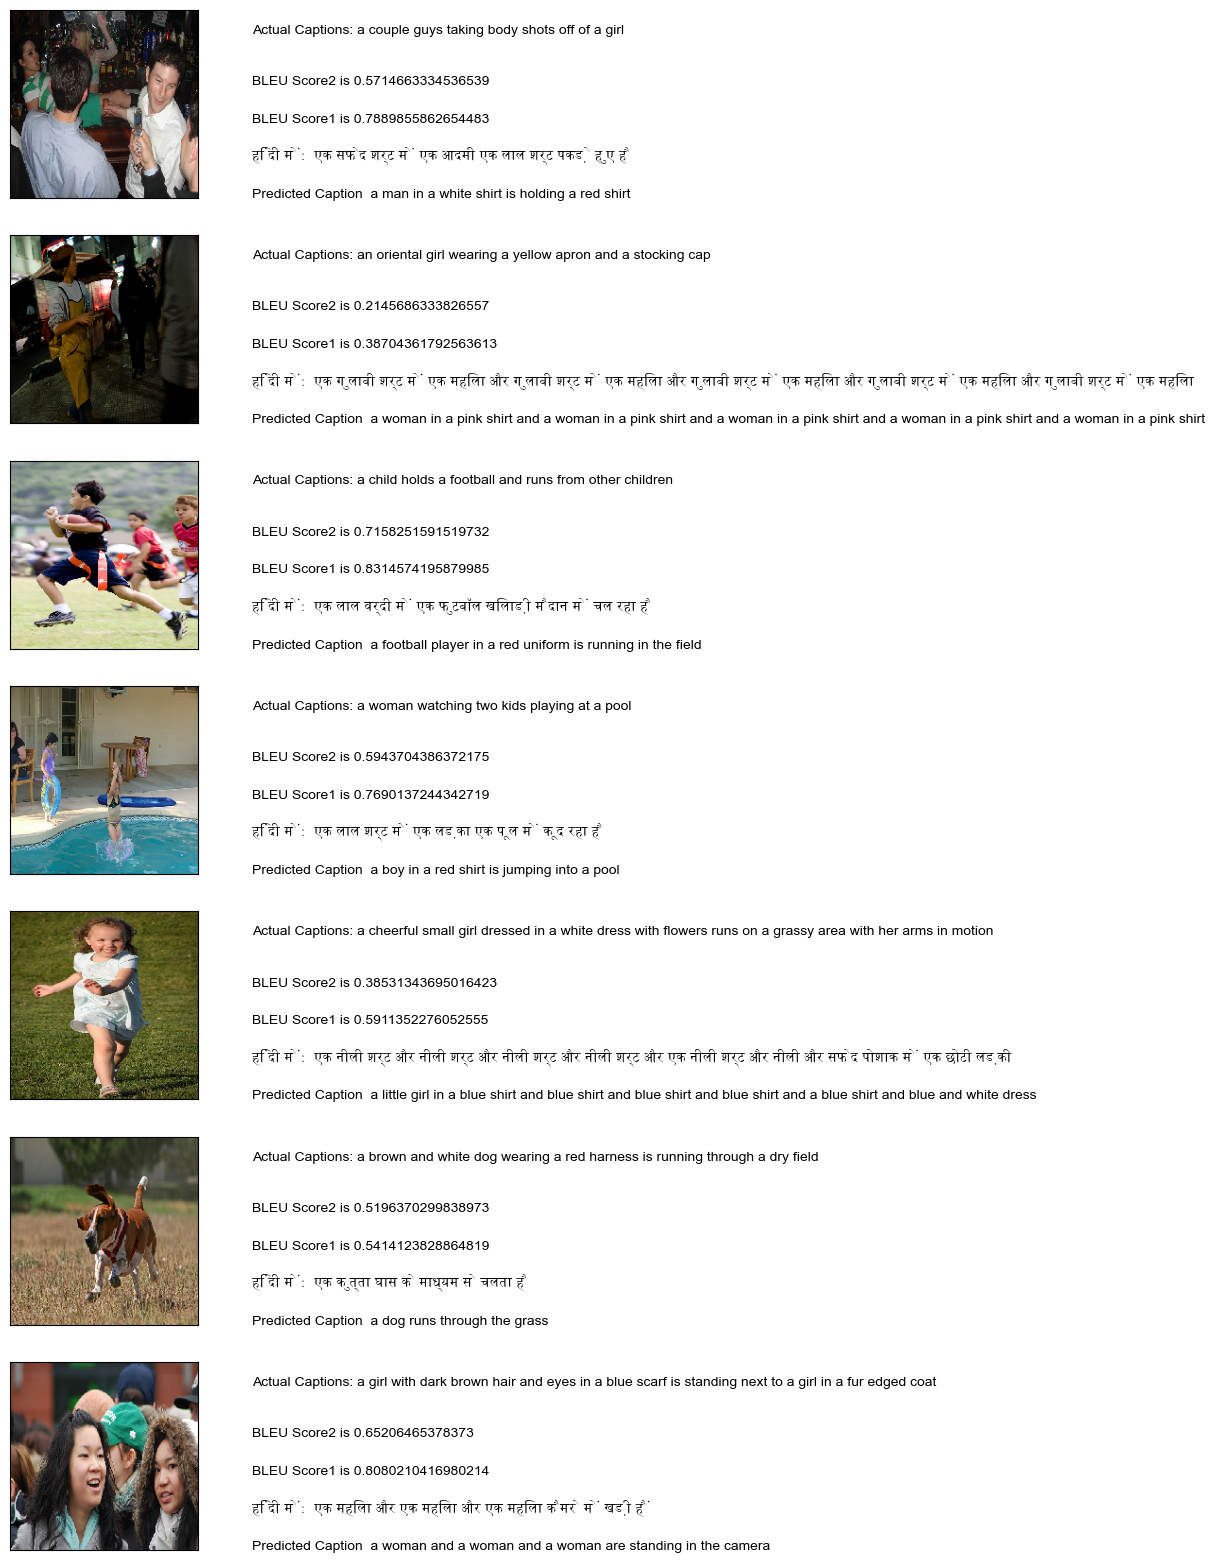

In [176]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" end", "") for x in actual_cap] # Removing the end token
        
        hyp = [generated_captions[filename]]

        ref = test_actual_captions[filename]
        weights1=(0.7, 0.1, 0.1, 0.1)
        weights2=(0.25, 0.25, 0.25, 0.25)

        res  = corpus_bleu([ref], hyp,weights=weights1)
        res2 = corpus_bleu([ref], hyp, weights=weights2)
        
        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,5)
        #for i, text in enumerate(caps_with_score):
        plt.rcParams['font.family'] = ['Arial']
        ax.text(0,0,f"Predicted Caption {hyp[0]}")
        plt.rcParams['font.family'] = ['Devanagari MT']
        ax.text(0,1,f"हिंदी में:  {translate_text(hyp[0],'english','hindi')}")
        plt.rcParams['font.family'] = ['Arial']
        ax.text(0,2,f"BLEU Score1 is {res}",fontsize=10)
        ax.text(0,3,f"BLEU Score2 is {res2}",fontsize=10)
        ax.text(0,4, "Actual Captions: "+actual_cap[0])
        count += 1
    plt.show()
visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

## End